# Cabeçalho de Identificação

**Nome:** Marcello Linard Teixeira
**RA:** 10419338
**Disciplina:** Inteligência Artificial – 7ºN CC - Noite
**Professor:** Prof. Dr. Ivan Carlos Alcântara de Oliveira

**Síntese do Conteúdo:**
Este notebook realiza a primeira etapa do projeto de predição de preços do Bitcoin. As etapas incluem:
1.  Carregamento dos dados históricos obtidos do portal Investing.com.
2.  Limpeza e pré-processamento dos dados, incluindo conversão de tipos e tratamento de valores.
3.  Análise Exploratória de Dados (EDA) para visualizar tendências, volatilidade e outras características da série temporal.
4.  Preparação dos dados para modelagem, incluindo normalização e criação de janelas deslizantes (sliding windows).
5.  Salvamento dos dados processados para serem utilizados nos próximos notebooks de modelagem.

Aviso: Não há dados suficientes para criar as janelas de treinamento.

Arquivos processados foram salvos com sucesso!


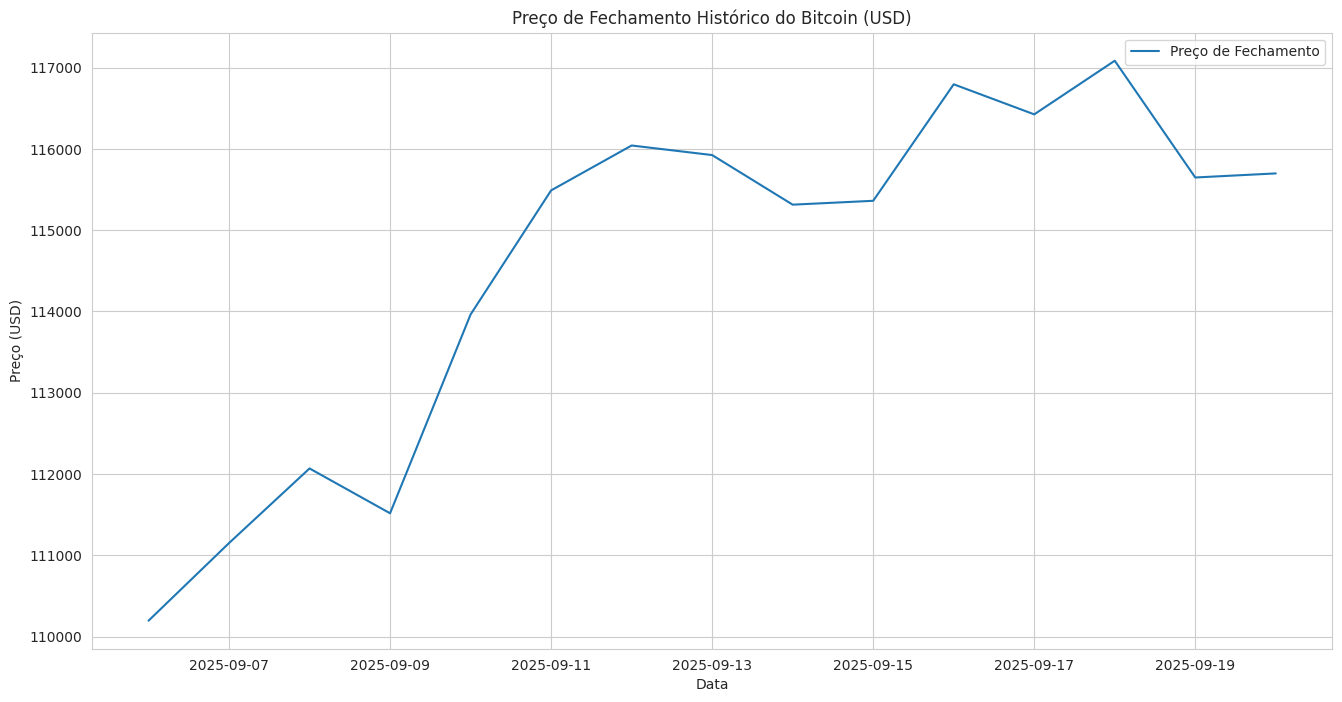

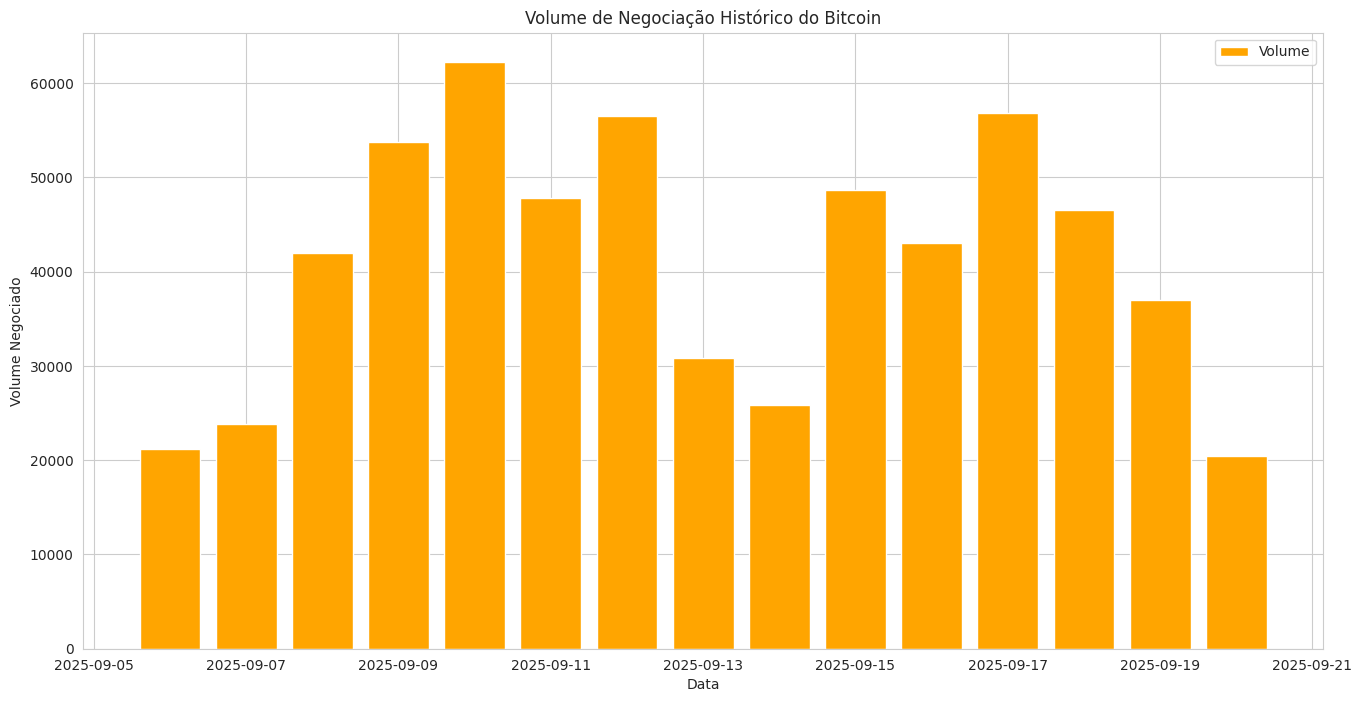

In [3]:

# ==============================================================================
# SEÇÃO 1: CONFIGURAÇÃO DO AMBIENTE E CARREGAMENTO DOS DADOS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import joblib

# Configurações de visualização para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

# Carrega o arquivo em um DataFrame do pandas.
file_name = 'Bitcoin Historical Data.csv'
df = pd.read_csv(file_name)


# ==============================================================================
# SEÇÃO 2: INSPEÇÃO INICIAL E LIMPEZA DOS DADOS
# ==============================================================================
def clean_data(df):
    df.columns = ['Date', 'Price', 'Open', 'High', 'Low', 'Vol', 'Change_Perc']
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    df.set_index('Date', inplace=True)
    cols_to_clean = ['Price', 'Open', 'High', 'Low']
    for col in cols_to_clean:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace(',', '', regex=False).astype(float)
    if df['Vol'].dtype == 'object':
        def convert_volume(vol_str):
            if isinstance(vol_str, str):
                vol_str = vol_str.strip()
                if vol_str.endswith('K'): return float(vol_str[:-1]) * 1_000
                if vol_str.endswith('M'): return float(vol_str[:-1]) * 1_000_000
                if vol_str == '-': return np.nan
            return float(vol_str)
        df['Vol'] = df['Vol'].apply(convert_volume)
    if df['Change_Perc'].dtype == 'object':
        df['Change_Perc'] = df['Change_Perc'].str.replace('%', '', regex=False).astype(float) / 100.0
    df.sort_index(ascending=True, inplace=True)

    # CORREÇÃO: Substituindo o método 'fillna' obsoleto
    df.ffill(inplace=True)

    return df

df_cleaned = clean_data(df.copy())


# ==============================================================================
# SEÇÃO 3: ANÁLISE EXPLORATÓRIA DE DADOS (EDA)
# ==============================================================================
# (Esta seção não precisa de alterações e irá gerar os mesmos gráficos)
plt.figure(figsize=(16, 8))
plt.title('Preço de Fechamento Histórico do Bitcoin (USD)')
plt.plot(df_cleaned.index, df_cleaned['Price'], label='Preço de Fechamento')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.savefig('price_history.png')

plt.figure(figsize=(16, 8))
plt.title('Volume de Negociação Histórico do Bitcoin')
plt.bar(df_cleaned.index, df_cleaned['Vol'], label='Volume', color='orange')
plt.xlabel('Data')
plt.ylabel('Volume Negociado')
plt.legend()
plt.savefig('volume_history.png')


# ==============================================================================
# SEÇÃO 4: PREPARAÇÃO DOS DADOS PARA MODELAGEM (COM CORREÇÃO)
# ==============================================================================
price_series = df_cleaned[['Price']].copy()
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price_series)

# CORREÇÃO: Função de criação de janelas mais robusta
def create_sliding_windows_robust(data, window_size):
    """
    Cria sequências de entrada (X) e saídas (y) pré-alocando arrays NumPy.
    """
    num_samples = len(data) - window_size
    if num_samples <= 0:
        return np.array([]), np.array([])

    # Pré-aloca os arrays para garantir o formato correto
    X = np.zeros((num_samples, window_size))
    y = np.zeros(num_samples)

    for i in range(num_samples):
        X[i] = data[i:i + window_size].flatten()
        y[i] = data[i + window_size]

    return X, y

WINDOW_SIZE = 60
X, y = create_sliding_windows_robust(price_scaled, WINDOW_SIZE)

# CORREÇÃO: Verifica se os dados foram criados antes de tentar o reshape
if X.shape[0] > 0:
    # Adiciona a terceira dimensão [samples, timesteps, features] para a LSTM
    X = np.expand_dims(X, axis=2)
    print(f"Formato de X (dados de entrada): {X.shape}")
    print(f"Formato de y (dados de saída): {y.shape}")
else:
    print("Aviso: Não há dados suficientes para criar as janelas de treinamento.")


# ==============================================================================
# SEÇÃO 5: SALVAMENTO DOS DADOS PROCESSADOS
# ==============================================================================
df_cleaned.to_csv('btc_data_cleaned.csv')
np.save('X_data_lstm.npy', X)
np.save('y_data_lstm.npy', y)
joblib.dump(scaler, 'price_scaler.pkl')

print("\nArquivos processados foram salvos com sucesso!")